# CONUS Great Plain domain forecast checks

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [4]:
need_publish = False

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

## Prep data

In [5]:
def hourly_datetimes(year: int) -> np.ndarray:
    start = np.datetime64(f"{year}-01-01T00:00:00", "ns")
    stop  = np.datetime64(f"{year+1}-01-01T00:00:00", "ns")  # exclusive
    hours = np.arange(start, stop, np.timedelta64(1, "h"))
    return hours

dt_list1 = hourly_datetimes(2021)
dt_list2 = hourly_datetimes(2022)
# len(dt_list[:273*24])

In [6]:
year = 2022

fn_fmt = '/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/final_{}_{}_WY.zarr'
fn_target = '/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/target_{}_WY.zarr'.format(year)

fn_ERA5_0 = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_BCSD/ERA5_GP_1h_{}.zarr'.format(year-1)
fn_ERA5_1 = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_BCSD/ERA5_GP_1h_{}.zarr'.format(year)

fn_GDAS_0 = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_GDAS/GDAS_GP_1h_{}.zarr'.format(year-1)
fn_GDAS_1 = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_GDAS/GDAS_GP_1h_{}.zarr'.format(year)


#'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_1h/ERA5_GP_1h_{}.zarr'.format(year)

In [7]:
dict_plot = {}

for exp_name in ['B3H', 'B6H', 'GDAS']:
    fn = fn_fmt.format(exp_name, year)
    ds = xr.open_zarr(fn)
    
    dict_plot[f'{exp_name}_T2'] = ds['WRF_T2']
    dict_plot[f'{exp_name}_PWAT'] = ds['WRF_PWAT']
    dict_plot[f'{exp_name}_MSLP'] = 1e-2 * ds['WRF_MSLP']
    dict_plot[f'{exp_name}_precip'] = ds['WRF_precip']
    
    dict_plot[f'{exp_name}_U10'] = ds['WRF_U10']
    dict_plot[f'{exp_name}_V10'] = ds['WRF_V10']
    dict_plot[f'{exp_name}_spd'] = np.sqrt(ds['WRF_U10']**2 + ds['WRF_V10']**2)

In [8]:
ds = xr.open_zarr(fn_target)
dict_plot['target_T2'] = ds['WRF_T2']
dict_plot['target_PWAT'] = ds['WRF_PWAT']
dict_plot['target_MSLP'] = 1e-2* ds['WRF_MSLP']
dict_plot['target_precip'] = ds['WRF_precip']
dict_plot['target_U10'] = ds['WRF_U10']
dict_plot['target_V10'] = ds['WRF_V10']
dict_plot['target_spd'] = np.sqrt(ds['WRF_U10']**2 + ds['WRF_V10']**2)
time_WRF = ds['time'].values

In [9]:
ds = xr.concat(
    [
        xr.open_zarr(fn_ERA5_0).sel(time=slice(f'{year-1}-10-01T00', f'{year-1}-12-31T23')), 
        xr.open_zarr(fn_ERA5_1).sel(time=slice(f'{year}-01-01T00', f'{year}-09-30T23'))
    ], dim='time'
).isel(time=slice(None, None, 6))

dict_plot['LR_ERA5_T2'] = ds['VAR_2T']
dict_plot['LR_ERA5_PWAT'] = 1e-3 * ds['total_column_water'] # to kg/m2
dict_plot['LR_ERA5_MSLP'] = 1e-2 * ds['MSL']
dict_plot['LR_ERA5_precip'] = 1e3 * ds['total_precipitation']
dict_plot['LR_ERA5_U10'] = ds['VAR_10U']
dict_plot['LR_ERA5_V10'] = ds['VAR_10V']
dict_plot['LR_ERA5_spd'] = np.sqrt(ds['VAR_10U']**2 + ds['VAR_10V']**2)


ds = xr.concat(
    [
        xr.open_zarr(fn_GDAS_0).sel(time=slice(f'{year-1}-10-01T00', f'{year-1}-12-31T23')), 
        xr.open_zarr(fn_GDAS_1).sel(time=slice(f'{year}-01-01T00', f'{year}-09-30T23'))
    ], dim='time'
)

dict_plot['LR_GDAS_T2'] = ds['VAR_2T']
dict_plot['LR_GDAS_PWAT'] = 1e-3 * ds['total_column_water'] # to kg/m2
dict_plot['LR_GDAS_MSLP'] = 1e-2 * ds['MSL']
dict_plot['LR_GDAS_precip'] = ds['total_precipitation']
dict_plot['LR_GDAS_U10'] = ds['VAR_10U']
dict_plot['LR_GDAS_V10'] = ds['VAR_10V']
dict_plot['LR_GDAS_spd'] = np.sqrt(ds['VAR_10U']**2 + ds['VAR_10V']**2)

time_LR = ds['time'].values

In [10]:
static_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_static = xr.open_zarr(static_name)
lon_WRF = ds_static['XLONG'].values
lat_WRF = ds_static['XLAT'].values

## Plot

In [11]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling
    # GL = ax.gridlines(crs=ccrs.PlateCarree(), 
    #                   draw_labels=False, x_inline=False, y_inline=False, 
    #                   color='k', linewidth=0.1, linestyle=':', zorder=5)
    # GL.top_labels = None; GL.bottom_labels = None
    # GL.right_labels = None; GL.left_labels = None
    # GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    # GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [12]:
fig_dir = '/glade/u/home/ksha/CONUS-404-prep/figures/'

In [13]:
dict_skip = {}
dict_skip['GDAS'] = dict_skip['B3H'] = dict_skip['B6H'] = dict_skip['target'] = slice(None, None, 1)
dict_skip['LR_ERA5']= slice(None, None, 7)
dict_skip['LR_GDAS'] = slice(None, None, 26)

In [14]:
# i_hour = 228; 2020-10-10 12:00:00

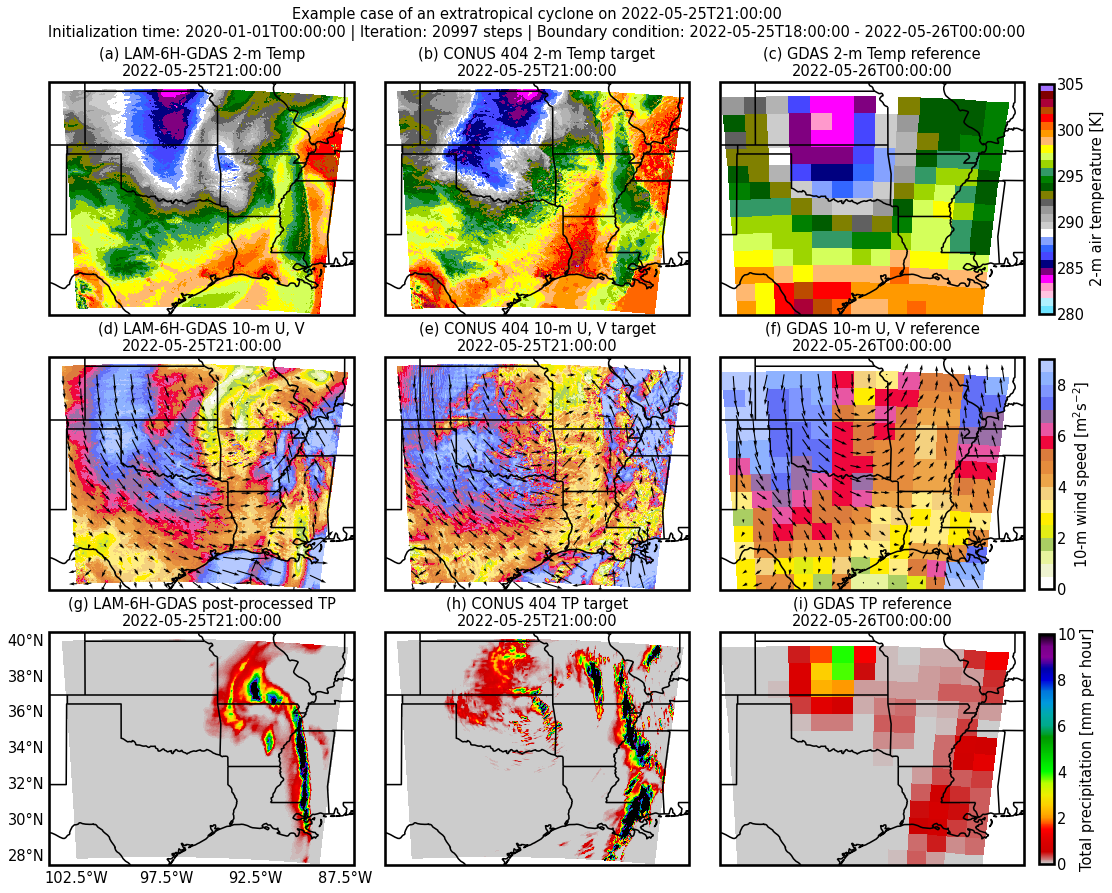

In [15]:
skip = slice(None, None, 20)

LIM_t2 = [280, 305]
LIM_spd = [0, 9]
LIM_precip = [0, 10]

cmap_t2 = cmaps.t2m_29lev
cmap_spd = cmaps.wind_17lev
cmap_precip = plt.cm.nipy_spectral_r
# gu.precip_cmap(return_rgb=False, land_map=False)

proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

i_hour = 5684 + 1

i_6hour = np.searchsorted(time_LR, time_WRF[i_hour])

fig = plt.figure(figsize=(13, 11), dpi=dpi_)
gs = gridspec.GridSpec(3, 3)

AX_maps = []
# GL_maps = []
AX_maps.append(plt.subplot(gs[0, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 1], projection=proj_))
AX_maps.append(plt.subplot(gs[0, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[1, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[1, 1], projection=proj_))
AX_maps.append(plt.subplot(gs[1, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 1], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2], projection=proj_))

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX_maps:
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)

i_ax = 6
ax = AX_maps[i_ax]
    
GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color=None, linewidth=0, zorder=5
)

GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}

GL.top_labels = None
#GL.left_labels = None
# GL.bottom_labels = None
GL.right_labels = None

# =================================================== #

for i_n, name in enumerate(['GDAS', 'target', 'LR_GDAS']):
    if i_n == 2:
        i_pick = i_6hour
    else:
        i_pick = i_hour

    CS1 = AX_maps[i_n].pcolormesh(
        lon_WRF[dict_skip[name], dict_skip[name]], 
        lat_WRF[dict_skip[name], dict_skip[name]], 
        dict_plot[f'{name}_T2'].isel(time=i_pick, south_north=dict_skip[name], west_east=dict_skip[name]),
        vmin=LIM_t2[0], vmax=LIM_t2[1], cmap=cmap_t2, transform=ccrs.PlateCarree()
    )
    
    CS2 = AX_maps[3+i_n].pcolormesh(
        lon_WRF[dict_skip[name], dict_skip[name]], 
        lat_WRF[dict_skip[name], dict_skip[name]], 
        dict_plot[f'{name}_spd'].isel(time=i_pick, south_north=dict_skip[name], west_east=dict_skip[name]), 
        vmin=LIM_spd[0], vmax=LIM_spd[1], cmap=cmap_spd, transform=ccrs.PlateCarree()
    )
    
    AX_maps[3+i_n].quiver(
        lon_WRF[skip, skip], 
        lat_WRF[skip, skip], 
        dict_plot[f'{name}_U10'].isel(time=i_pick, south_north=skip, west_east=skip),
        dict_plot[f'{name}_V10'].isel(time=i_pick, south_north=skip, west_east=skip),
        color='k', scale=150, transform=ccrs.PlateCarree()
    )
    
    CS3 = AX_maps[6+i_n].pcolormesh(
        lon_WRF[dict_skip[name], dict_skip[name]], 
        lat_WRF[dict_skip[name], dict_skip[name]], 
        dict_plot[f'{name}_precip'].isel(time=i_pick, south_north=dict_skip[name], west_east=dict_skip[name]),
        vmin=LIM_precip[0], vmax=LIM_precip[1], cmap=cmap_precip, transform=ccrs.PlateCarree()
    )
    
time_init = '2020-01-01T00:00:00'
time_valid = np.datetime_as_string(time_WRF[i_hour], unit='h')+':00:00'
time_valid_ERA5_0 = np.datetime_as_string(time_LR[i_6hour-1], unit='h')+':00:00'
time_valid_ERA5 = np.datetime_as_string(time_LR[i_6hour], unit='h')+':00:00'

AX_maps[0].set_title('(a) LAM-6H-GDAS 2-m Temp\n{}'.format(time_valid), fontsize=14)
AX_maps[1].set_title('(b) CONUS 404 2-m Temp target\n{}'.format(time_valid), fontsize=14)
AX_maps[2].set_title('(c) GDAS 2-m Temp reference\n{}'.format(time_valid_ERA5), fontsize=14)

AX_maps[3].set_title('(d) LAM-6H-GDAS 10-m U, V\n{}'.format(time_valid), fontsize=14)
AX_maps[4].set_title('(e) CONUS 404 10-m U, V target\n{}'.format(time_valid), fontsize=14)
AX_maps[5].set_title('(f) GDAS 10-m U, V reference\n{}'.format(time_valid_ERA5), fontsize=14)

AX_maps[6].set_title('(g) LAM-6H-GDAS post-processed TP\n{}'.format(time_valid), fontsize=14)
AX_maps[7].set_title('(h) CONUS 404 TP target\n{}'.format(time_valid), fontsize=14)
AX_maps[8].set_title('(i) GDAS TP reference\n{}'.format(time_valid_ERA5), fontsize=14)

ax_base1 = fig.add_axes([1.015, 0.694, 0.05, 0.279])
ax_base1.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax1 = inset_axes(ax_base1, height='100%', width='30%', borderpad=0, loc=2)
CBar1 = plt.colorbar(CS1, orientation='vertical', cax=cax1)
CBar1.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar1.outline.set_linewidth(2.5)
CBar1.ax.set_ylabel('2-m air temperature [K]', fontsize=14)#, labelpad=-47.5)

ax_base2 = fig.add_axes([1.015, 0.36, 0.05, 0.279])
ax_base2.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax2 = inset_axes(ax_base2, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = plt.colorbar(CS2, orientation='vertical', cax=cax2)
CBar2.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)
CBar2.ax.set_ylabel('10-m wind speed [$\mathsf{m^2s^{-2}}$]', fontsize=14)

ax_base3 = fig.add_axes([1.015, 0.027, 0.05, 0.279])
ax_base3.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3 = inset_axes(ax_base3, height='100%', width='30%', borderpad=0, loc=2)
CBar3 = plt.colorbar(CS3, orientation='vertical', cax=cax3)
CBar3.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar3.outline.set_linewidth(2.5)
CBar3.ax.set_ylabel('Total precipitation [mm per hour]', fontsize=14)


ax_title1 = fig.add_axes([0.0, 1.03, 1.0, 0.03])

ax_title1.text(
    0.5, 0.5, 
    'Example case of an extratropical cyclone on {}\n'
    'Initialization time: {} | Iteration: {} steps | '
    'Boundary condition: {} - {}'.format(time_valid, time_init, 15312+i_hour, time_valid_ERA5_0, time_valid_ERA5), 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.set_axis_off()
ax_base1.set_axis_off()
ax_base2.set_axis_off()
ax_base3.set_axis_off()

# if need_publish:
#     fig.savefig(fig_dir+'example_front_{:04d}k.png'.format(int(i_hour)), format='png', **fig_keys)

### Cold / warm front markers

In [16]:
from matplotlib.patches import Polygon, Circle

In [37]:
def cold_front_patches(x0, y0, x1, y1, spacing=1.0, size=0.2):
    """
    Create triangle patches along a line representing a cold front.
    x0, y0 -> x1, y1 : end points of the front
    spacing : spacing between triangles (in data units)
    size : triangle size (in data units)
    """
    patches = []

    # direction vector and length
    dx = x1 - x0
    dy = y1 - y0
    L = (dx**2 + dy**2) ** 0.5
    if L == 0:
        return patches

    # unit vector along front
    ux, uy = dx / L, dy / L
    # unit normal (to one side)
    nx, ny = -uy, ux

    # positions along line
    n_sym = int(L // spacing)
    for i in range(1, n_sym + 1):
        t = i * spacing
        px = x0 + ux * t
        py = y0 + uy * t

        # triangle base centered at px,py, pointing toward normal
        base_half = size / 2
        tip = (px + nx * size, py + ny * size)
        base1 = (px - ux * base_half - nx * base_half, py - uy * base_half - ny * base_half)
        base2 = (px + ux * base_half - nx * base_half, py + uy * base_half - ny * base_half)

        tri = Polygon([base1, base2, tip], closed=True)
        patches.append(tri)

    return patches

In [46]:
def warm_front_patches(x0, y0, x1, y1, spacing=1.0, radius=0.2):
    """
    Create semicircle patches along a line representing a warm front.
    """
    patches = []

    dx = x1 - x0
    dy = y1 - y0
    L = (dx**2 + dy**2) ** 0.5
    if L == 0:
        return patches

    ux, uy = dx / L, dy / L
    nx, ny = -uy, ux  # normal

    n_sym = int(L // spacing)
    for i in range(1, n_sym + 1):
        t = i * spacing
        px = x0 + ux * t
        py = y0 + uy * t

        # center of full circle (we'll just see the half visually if the line covers it)
        cx = px + nx * radius
        cy = py + ny * radius

        circ = Circle((cx, cy), radius=radius)
        patches.append(circ)

    return patches

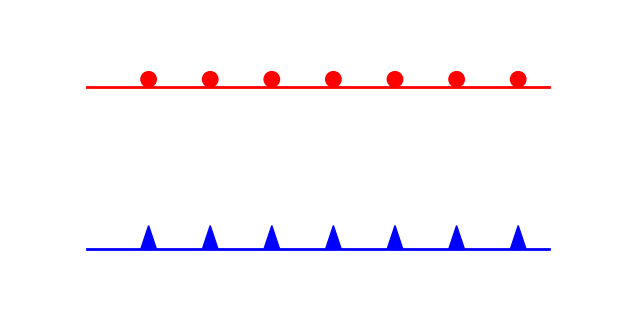

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))

# 1) Cold front: left to right
x0, y0 = 0, 0
x1, y1 = 6, 0
pad = 0.1
ax.plot([x0, x1], [y0-pad, y1-pad], 'b-', linewidth=2)

for p in cold_front_patches(x0, y0, x1, y1, spacing=0.8, size=0.2):
    p.set_edgecolor('blue')
    p.set_facecolor('blue')
    ax.add_patch(p)

# 2) Warm front: left to right, shifted up
x0, y0 = 0, 2
x1, y1 = 6, 2
ax.plot([x0, x1], [y0, y1], 'r-', linewidth=2)

for p in warm_front_patches(x0, y0, x1, y1, spacing=0.8, radius=0.1):
    p.set_edgecolor('r')
    p.set_facecolor('r')  # outline only
    ax.add_patch(p)

# Formatting
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, 7)
ax.set_ylim(-1, 3)
ax.set_axis_off()

ffmpeg -framerate 3 -pattern_type glob -i 'example_front_????k.png' -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -pix_fmt yuv420p example_front.mp4